In [9]:
import torch
from torch.nn import functional as F

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import plot_trace, default_nbeta

from tracr.haiku_to_pytorch import haiku_to_pytorch, apply
from torchinfo import summary

from rasp_models.peak import get_peak_model
from datasets.dataloaders import makePeakDataLoader

In [10]:
loader = makePeakDataLoader()

In [11]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = get_peak_model()
torch_model = haiku_to_pytorch(model).to(DEVICE)

In [12]:
def evaluate(model, data):
    inputs, outputs = data[0]

    model_output = model.forward(inputs)

    if torch.isnan(sum(sum(sum(model_output)))):
        print(inputs)
        print(outputs)
        print(model_output)

    loss = F.cross_entropy(model_output, outputs)
    return loss, {
        "logits": model_output
    }

In [13]:
summary(torch_model)

Layer (type:depth-idx)                   Param #
TracrTransformer                         --
├─ModuleList: 1-1                        --
│    └─TracrBlock: 2-1                   --
│    │    └─TracrAttention: 3-1          24,655
│    │    └─TracrMLP: 3-2                51,127
│    └─TracrBlock: 2-2                   --
│    │    └─TracrAttention: 3-3          24,655
│    │    └─TracrMLP: 3-4                51,127
│    └─TracrBlock: 2-3                   --
│    │    └─TracrAttention: 3-5          24,655
│    │    └─TracrMLP: 3-6                51,127
│    └─TracrBlock: 2-4                   --
│    │    └─TracrAttention: 3-7          24,655
│    │    └─TracrMLP: 3-8                51,127
│    └─TracrBlock: 2-5                   --
│    │    └─TracrAttention: 3-9          24,655
│    │    └─TracrMLP: 3-10               51,127
│    └─TracrBlock: 2-6                   --
│    │    └─TracrAttention: 3-11         24,655
│    │    └─TracrMLP: 3-12               51,127
Total params: 454,692
T

In [14]:
print(torch_model)

TracrTransformer(
  (layers): ModuleList(
    (0-5): 6 x TracrBlock(
      (attn): TracrAttention(
        (query): Linear(in_features=127, out_features=48, bias=True)
        (key): Linear(in_features=127, out_features=48, bias=True)
        (value): Linear(in_features=127, out_features=48, bias=True)
        (output): Linear(in_features=48, out_features=127, bias=True)
      )
      (mlp): TracrMLP(
        (linear1): Linear(in_features=127, out_features=200, bias=True)
        (linear2): Linear(in_features=200, out_features=127, bias=True)
      )
    )
  )
)


In [15]:
all_llcs = []

for _ in range(3):
    learning_coeff_stats = estimate_learning_coeff_with_summary(
        torch_model,
        loader=loader,
        evaluate=evaluate,
        sampling_method=SGLD,
        optimizer_kwargs=dict(lr=1e-6, localization=1.0, nbeta=default_nbeta(loader)),
        num_chains=10,  # How many independent chains to run
        num_draws=100,  # How many samples to draw per chain
        num_burnin_steps=0,  # How many samples to discard at the beginning of each chain
        num_steps_bw_draws=1,  # How many steps to take between each sample
        device=DEVICE,
        online=True,
    )
    trace = learning_coeff_stats["loss/trace"]
    llc_avg = sum(learning_coeff_stats['llc/means'])/len(learning_coeff_stats['llc/means'])
    all_llcs.append(llc_avg)
    print(round(llc_avg, 2))

overall_avg_llc = sum(all_llcs) / len(all_llcs)
print(f"\nOverall average LLC across 3 runs: {round(overall_avg_llc, 2)}")

Chain 9: 100%|██████████| 100/100 [00:02<00:00, 33.66it/s]


2.26


Chain 9: 100%|██████████| 100/100 [00:03<00:00, 30.42it/s]


1.51


Chain 9: 100%|██████████| 100/100 [00:03<00:00, 26.18it/s]

2.99

Overall average LLC across 3 runs: 2.25


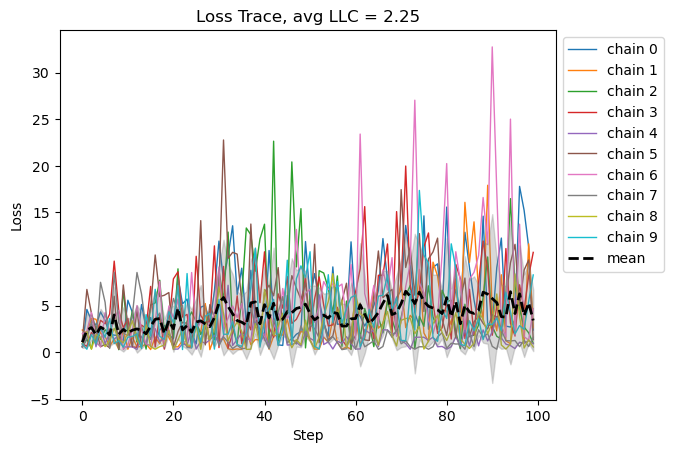

<Figure size 1200x900 with 0 Axes>

In [16]:
plot_trace(
    trace,
    "Loss",
    x_axis="Step",
    title=f"Loss Trace, avg LLC = {overall_avg_llc:.2f}",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 9),
    true_lc=None,
)